In [1]:
#Dal sito: https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html
from qiskit import *
from qiskit.tools.jupyter import *

In [4]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

ibmqfactory.load_account:WARNING:2021-09-16 10:01:36,930: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [6]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [7]:
backend_defaults = backend.defaults()

In [8]:
import numpy as np

GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0   # qubit che studiamo
mem_slot = 0    # Memory slot

# Centro della finestra di sweep. Frequenza espressa in Hertz
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]

print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# Fattore di scala (per comodità)
scale_factor = 1e-14

# Ampiezza finestra di sweep
frequency_span_Hz = 40 * MHz
# step di cui mi muovo all'interno della finestra
frequency_step_Hz = 1 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

# Vettore np delle freq. dell'esperimento. Definisco primo, ultimo numero del vettore e la spaziatura tra i valori
frequencies_GHz = np.arange(frequency_min / GHz, frequency_max / GHz, frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.971602155083083 GHz.
The sweep will go from 4.9516021550830835 GHz to 4.991602155083084 GHz in steps of 1.0 MHz.


In [9]:
# Siccome i samples devono essere in numero multiplo di 16, definisco una funzione
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [10]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.075 * us                            # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Creare il programma di base
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz

schedules = [sweep_sched.assign_parameters({freq : f}, inplace=False) for f in frequencies_Hz]

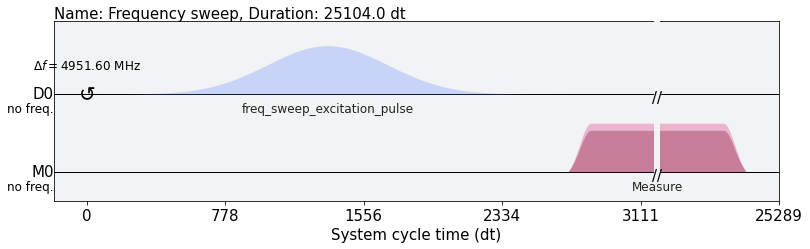

In [11]:
schedules[0].draw() #Argomento backend=backend

In [12]:
num_shots_per_frequency = 1024

job = backend.run(schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [13]:
# Monitoro lo stato del job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [14]:
# Recupero i risultati
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

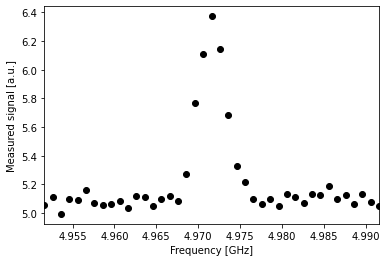

In [15]:
# Estraggo i risultati e li plotto
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [16]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [19]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

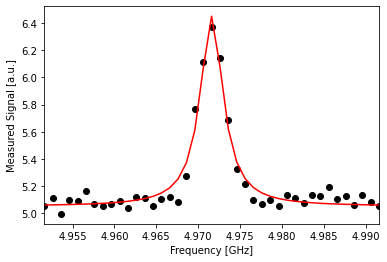

In [20]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')

plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [21]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.9716 GHz to 4.97161 GHz.


In [22]:
#CALIBRATING AND USING A PI_PULSE ( 3 )

In [23]:
# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [24]:
#ESPERIMENTO: invio impulsi al qubit alla sua freq. di risonanza, effettuo una misura e itero il procedimento per
            # diverse ampiezze di segnale
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

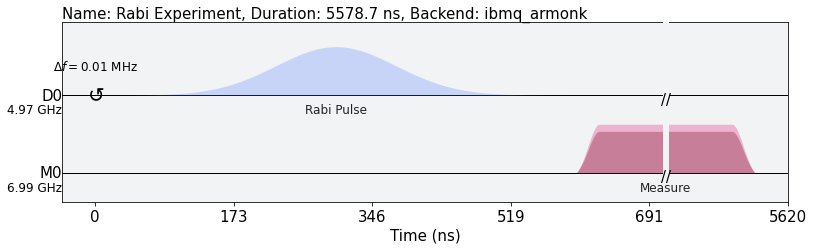

In [25]:
rabi_schedules[-1].draw(backend=backend)

In [26]:
num_shots_per_point = 1024

job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [27]:
rabi_results = job.result(timeout=120)

In [28]:
# Ottenuti i risultati, li fittiamo per cercare l'ampiezza del segnale necessaria. L'ampiezza della sinusoide
# la frazione di volte in cui un qubit era in |0> o |1> per ogni data ampiezza.
    
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

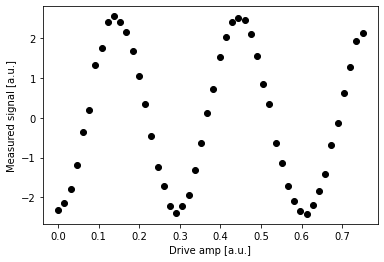

In [29]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

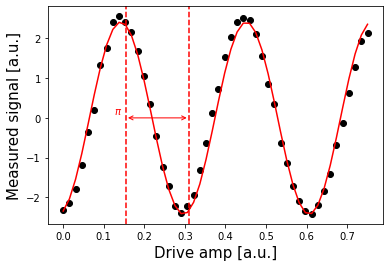

In [30]:
# Ora fitto questi dati con una sinusoide
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
#plt.savefig('Amp_pi.png')
plt.show()

In [31]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.15471736742423706


In [ ]:
# Definisco il mio impulso in base ai risultati appena ottenuti!!
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,        #Impulso gaussiano coi parametri ottenuti
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [ ]:
# Distinguere tra |0> e |1>. Creo due programmi: uno per lo stato fondamentale e uno per lo stato
        # eccitato. Idea: ho trovato come ruotare di pi il mio stato sulla sfera di Bloch
        # ora osservo le misure che seguono ad una rotazione per interpretare cosa è |0> e cosa
        # invece è |1>

In [ ]:
# Create two schedules

# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

In [ ]:
gnd_schedule.draw(backend=backend)

In [ ]:
exc_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 1024

job = backend.run([gnd_schedule, exc_schedule], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
gnd_exc_results = job.result(timeout=120)

In [ ]:
# Mostro i risultati del job nel quale ho preparato i due diversi stati per iniziare a distinguerli
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("|0> - |1> discrimination", fontsize=15)
#plt.savefig('Discr.png')
plt.show()

In [ ]:
# Ora creo una funzione Discriminator che meglio distingue i due stati (avendo trovato la media per quelli
        # che seguono ad una preparazione di ground o di excited)
        # La funzione ritorna 0 se una successiva misura (di qualsiasi altro esperimento/impulso) è più
        # vicina alla media dei punti ottenuti con preparazione di 'ground' e 1 se invece più vicino all'
        # altro punto di media.
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))


In [ ]:
#  R E L A X A T I O N

In [ ]:
# Misura del T1, ovvero il tempo di decadimento da stato eccitato a stato di ground
    # IDEA: simile a prima -> Applico un pi_pulse ed effettuo una misura MA queste due operazioni NON le svolgo
    # immediatamente. Inseriamo tra i due un certo intervallo di lunghezza via via crescente e creiamo un grafico
    # che mostra la frazione di misure che restituiscono |1> in funzione della durata dell'intervallo.
    # Definiamo T1 il tempo caratteristico della decrescita esponenziale osservata.
    
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [ ]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"T1 delay = {delay / ns} ns") as t1_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_qubit_frequency, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    t1_schedules.append(t1_schedule)

In [ ]:
# PROVARE A RIPETERE CON DIVERSI VALORI DI sched.idx
sched_idx = 0
t1_schedules[sched_idx].draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(t1_schedules, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
t1_results = job.result(timeout=120)

In [ ]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

In [ ]:
# Fit the data
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
#plt.savefig('Relaxation.png')
plt.show()

In [ ]:
# Determing QUBIT Coherence ( 4 ) 
#
#

In [ ]:
# Esperimento di Ramsey

# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [ ]:
detuning_MHz = 2
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [ ]:
# create schedules for Ramsey experiment 
ramsey_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"Ramsey delay = {delay / ns} ns") as ramsey_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(ramsey_frequency, drive_chan)
        pulse.call(x90_pulse)                                                                  #Implulso pi/2
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)   #Delay
        pulse.call(x90_pulse)                                                                  #Impulso pi/2
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])                  #Misura
    ramsey_schedules.append(ramsey_schedule)

In [ ]:
ramsey_schedules[2].draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(ramsey_schedules, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
ramsey_results = job.result(timeout=120)

In [ ]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [ ]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
#plt.savefig('Ramsey.png')
plt.show()

In [ ]:
precise_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

In [ ]:
# Measuring T2 using Hanh Echoes
#
#

In [ ]:
# Simile al Ramsey Experiment: sequenza di impulsi pi/2, pi e pi/2
# Il tempo di decadimento di quest'esperimento retituisce T2: tempo di coerenza

In [ ]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

In [ ]:
t2_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"T2 delay = {delay / ns} ns") as t2_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(precise_qubit_freq, drive_chan)
        pulse.call(x90_pulse)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.call(x90_pulse)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    t2_schedules.append(t2_schedule)

In [12]:
t2_schedules[-1].draw(backend=backend)

NameError: name 't2_schedules' is not defined

In [13]:
# Execution settings
num_shots_per_point = 512

job = backend.run(t2_schedules,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

job_monitor(job)

NameError: name 't2_schedules' is not defined

In [14]:
t2_results = job.result(timeout=120)

NameError: name 'job' is not defined

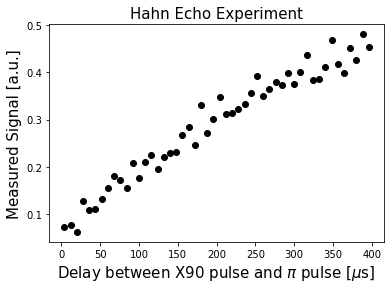

In [77]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

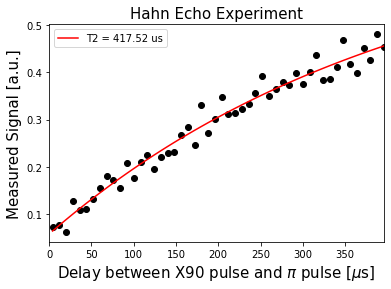

In [78]:
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.savefig('Hanh.png')
plt.show()

In [146]:
# DYNAMICAL DECOUPLING
#
#

In [147]:
# Tecnica usata per eliminare certe frequenze di rumore e allungare così il tempo di coerenza

In [148]:
# DD experiment parameters
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 # apply 1 sequence
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

Total time ranges from 2.0 to 354.0 us


In [149]:
T2DD_schedules = []

for delay in taus_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"T2DD delay = {delay /ns} ns") as T2DD_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(precise_qubit_freq, drive_chan)
        pulse.call(x90_pulse)                                                                        #impulso pi/2
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay/2)), drive_chan)       #delay
        for loop_counts in range(num_sequence):                                                      #ciclo for
            pulse.call(pi_pulse)                                                                     #impulso pi
            pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)     #delay
            with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
                pulse.call(pi_pulse)                                                                 #impulso pi
            pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)     #delay
            pulse.call(pi_pulse)                                                                     #impulso pi
            pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)     #delay
            with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
                pulse.call(pi_pulse)                                                                 #impulso pi
            if loop_counts != num_sequence-1:                                                        #if
                pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay/2)), drive_chan)       #delay
        pulse.call(x90_pulse)                                                                        #impulso pi/2
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    T2DD_schedules.append(T2DD_schedule)

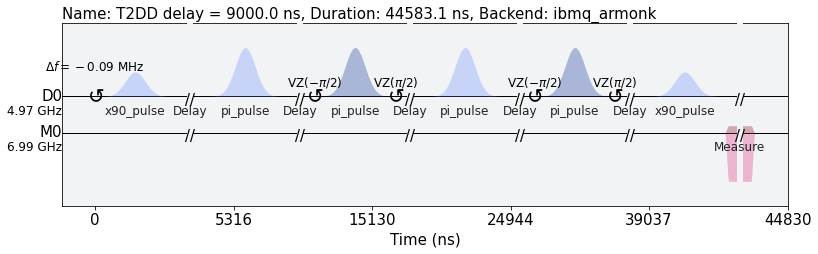

In [150]:
T2DD_schedules[2].draw(backend=backend)

In [151]:
num_shots_per_point = 1024

job = backend.run(T2DD_schedules,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)


job_monitor(job)

Job Status: job has successfully run


In [152]:
T2DD_results = job.result(timeout=120)

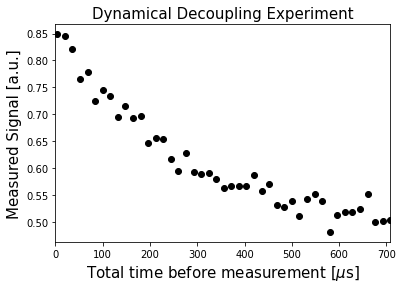

In [153]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

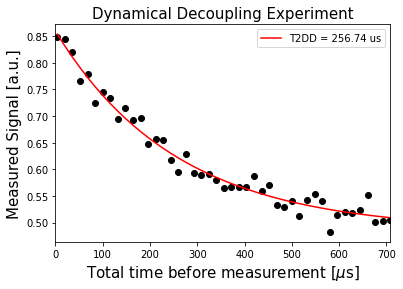

In [154]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()